In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import plotly.graph_objects as go
from scipy.signal import spectrogram

# Chirp Signal

The chirp signal that we will be using is a quadratic-phase modulated chirp signal has the following form:
$$
s(t) = sin(2\pi f_c t + \pi \gamma (t-\frac{T_p}{2})^2)
$$
where
- $f_c$ is the centred frequency of the chirp signal
- $t$ is the time variable (independent variable)
- $\gamma$ is the chirp rate $(Hz/s)$ defined as $\frac{Bandwidth}{Pulse Width}$
- $T_p$ is the pulse duration


## Chirp Rate
How does the chirp rate come about? Below we derive the chirp rate formula:
To simplify, we consider a linearly modulated chirp signal. We thus have the instantaneous frequency to be:
$$
f(t) = f_c + \gamma (t - \frac{T_p}{2})
$$

This means that at $t = 0$: 
$$
f(0) = f_c - \gamma \frac{T_p}{2}
$$

at $t = T_p$:
$$
f(T_p) = f_c + \gamma \frac{T_p}{2}
$$

and at $t = \frac{T_p}{2}$:
$$
f(\frac{T_p}{2}) = f_c
$$
The quadratic phase modulation or frequency sweep is centred at $t = \frac{T_p}{2}$ which is where $f_c$ lies.

So the total frequency range (bandwidth) spanned by the chirp is:
$$
BW = f(T_p) - f(0) = (f_c + \gamma \frac{T_p}{2}) - (f_c - \gamma \frac{T_p}{2}) = \gamma T_p
$$

We thus derive:
$$ 
\gamma  = \frac{BW}{T_p}
$$

Intuitively, this means that
- The longer pulse $T_p$, the slower the frequency sweep must be to span a given bandwidth.
- The larger the bandwidth, the faster you need to sweep.

In [2]:
def plot_spectrogram(signal, fs, title, ax):
    """
    Plot the spectrogram of a signal using matplotlib.

    Parameters:
    - signal: time-domain signal
    - fs: sampling frequency
    - title: plot title
    - ax: matplotlib axis
    """
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256, noverlap=128)
    ax.pcolormesh(t * 1e3, f / 1e3, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
    ax.set_ylabel('Frequency (kHz)')
    ax.set_xlabel('Time (ms)')
    ax.set_title(title)
    ax.set_ylim(0, fs / 2 / 1e3)

In [3]:
def compare_chirp_with_all_views(fc=50e3, gamma=1e6, Tp=1e-3, fs=2e6):
    """
    Compare uncentred and centred chirps with:
    - Time-domain waveform
    - Spectrogram
    - Instantaneous frequency
    - FFT magnitude (with bandwidth overlay)
    """
    t = np.linspace(0, Tp, int(fs * Tp))
    uncentred = np.sin(2 * np.pi * fc * t + np.pi * gamma * t**2)
    centred = np.sin(2 * np.pi * fc * t + np.pi * gamma * (t - Tp / 2)**2)

    # Instantaneous frequency
    inst_freq_uncentred = fc + gamma * t
    inst_freq_centred = fc + gamma * (t - Tp / 2)

    # FFT helper
    def compute_fft(signal):
        N = len(signal)
        fft_vals = np.fft.fft(signal)
        fft_freqs = np.fft.fftfreq(N, d=1/fs)
        return fft_freqs[:N//2], np.abs(fft_vals[:N//2])

    freq_u, mag_u = compute_fft(uncentred)
    freq_c, mag_c = compute_fft(centred)

    # Theoretical bandwidth
    B = gamma * Tp
    f_start = fc - B / 2
    f_end = fc + B / 2

    fig, axs = plt.subplots(4, 2, figsize=(14, 12))

    # Row 1: Time-domain waveform
    axs[0, 0].plot(t * 1e3, uncentred)
    axs[0, 0].set_title('Uncentred Chirp')
    axs[0, 0].set_ylabel('Amplitude')
    axs[0, 0].set_xlabel('Time (ms)')

    axs[0, 1].plot(t * 1e3, centred)
    axs[0, 1].set_title('Centred Chirp')
    axs[0, 1].set_ylabel('Amplitude')
    axs[0, 1].set_xlabel('Time (ms)')

    # Row 2: Spectrogram
    plot_spectrogram(uncentred, fs, 'Spectrogram (Uncentred)', axs[1, 0])
    plot_spectrogram(centred, fs, 'Spectrogram (Centred)', axs[1, 1])

    # Row 3: Instantaneous frequency
    axs[2, 0].plot(t * 1e3, inst_freq_uncentred / 1e3, color='red')
    axs[2, 0].set_title('Instantaneous Frequency (Uncentred)')
    axs[2, 0].set_ylabel('Freq (kHz)')
    axs[2, 0].set_xlabel('Time (ms)')

    axs[2, 1].plot(t * 1e3, inst_freq_centred / 1e3, color='red')
    axs[2, 1].set_title('Instantaneous Frequency (Centred)')
    axs[2, 1].set_ylabel('Freq (kHz)')
    axs[2, 1].set_xlabel('Time (ms)')

    # Row 4: FFT
    axs[3, 0].plot(freq_u / 1e3, mag_u, label='Uncentred FFT', linestyle='--')
    axs[3, 0].axvline(f_start / 1e3, color='r', linestyle=':', label='BW Start')
    axs[3, 0].axvline(f_end / 1e3, color='r', linestyle=':', label='BW End')
    axs[3, 0].set_title('FFT Spectrum (Uncentred)')
    axs[3, 0].set_xlabel('Freq (kHz)')
    axs[3, 0].set_ylabel('Magnitude')
    axs[3, 0].legend()

    axs[3, 1].plot(freq_c / 1e3, mag_c, label='Centred FFT')
    axs[3, 1].axvline(f_start / 1e3, color='r', linestyle=':', label='BW Start')
    axs[3, 1].axvline(f_end / 1e3, color='r', linestyle=':', label='BW End')
    axs[3, 1].set_title('FFT Spectrum (Centred)')
    axs[3, 1].set_xlabel('Freq (kHz)')
    axs[3, 1].set_ylabel('Magnitude')
    axs[3, 1].legend()

    plt.tight_layout()
    plt.show()



In [4]:
interact(compare_chirp_with_all_views,
         fc=FloatSlider(min=10e3, max=200e3, step=10e3, value=50e3, description='f_c (Hz)'),
         gamma=FloatSlider(min=1e4, max=1e7, step=1e5, value=1e6, description='γ (Hz/s)'),
         Tp=FloatSlider(min=0.1e-3, max=5e-3, step=0.1e-3, value=1e-3, description='T_p (s)'),
         fs=FloatSlider(min=1e5, max=10e6, step=1e5, value=2e6, description='fs (Hz)')
        );

interactive(children=(FloatSlider(value=50000.0, description='f_c (Hz)', max=200000.0, min=10000.0, step=10000…

## Target Simulation 1D
Now that we have understand the chirp signal and the importance of its properties, we will now simulate target recognition in 1-Dimension.

In this simulation, we will be simulating two targets at a certain distance away from the radar. The radar would emit the quadratic-phase modulated chirp signal:
$$
s(t) = sin(2\pi f_c t + \pi \gamma (t-\frac{T_p}{2})^2)
$$

In [5]:
time_delay = lambda distance: 2 * distance/ 3e8


def generate_delayed_signal(tx_signal, fs, t, delay, attenuation=1.0):
    delay_samples = int(np.round(delay * fs))
    if delay_samples >= len(t):
        return np.zeros_like(t)
    padded = np.zeros_like(t)
    padded[delay_samples:] = tx_signal[:len(t) - delay_samples] * attenuation
    return padded


def compute_received_signal(tx_signal, fs, t, target1_dist, target2_dist):
    # Compute delays
    tau1 = time_delay(target1_dist)
    tau2 = time_delay(target2_dist)

    # Received signal = echo from both targets
    rx_signal = generate_delayed_signal(tx_signal, fs, t, tau1) + generate_delayed_signal(tx_signal, fs, t, tau2)
    return rx_signal


def simulate_two_targets(
    target1=50.0, target2=50.0,
    fc=50e3, gamma=1e6, Tp=1e-3, fs=2e6
):
    """
    Simulates transmitted and received chirp signals for two targets at different distances.

    Parameters:
    - target1, target2: distances of the two targets in metres
    - fc: carrier frequency (Hz)
    - gamma: chirp rate (Hz/s)
    - Tp: pulse duration (s)
    - fs: sampling frequency (Hz)
    """
    t = np.linspace(0, Tp, int(fs * Tp)) # Create evenly spaced sampling based on number of samples
    tx_signal = np.sin(2 * np.pi * fc * t + np.pi * gamma * (t - Tp / 2)**2)

    rx_signal =  compute_received_signal(tx_signal, fs, t, target1, target2)

    # Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t*1e3, y=tx_signal, mode='lines', name='Transmitted'))
    fig.add_trace(go.Scatter(x=t*1e3, y=rx_signal, mode='lines', name='Received (2 Targets)'))

    fig.update_layout(title=(
        f'2-Target Simulation | Target1: {target1:.1f} m, Target2: {target2:.1f} m'),
        xaxis_title='Time (ms)',
        yaxis_title='Amplitude',
        legend_title='Signal')
    fig.show()


    N = len(rx_signal)

    # Perform shifted FFT
    N = len(rx_signal)
    fft_vals = np.fft.fft(rx_signal)
    fft_vals_shifted = np.fft.fftshift(fft_vals)

    fft_freqs = np.fft.fftfreq(N, d=1/fs) # from -fs/2 to +fs/2
    fft_freqs_shifted = np.fft.fftshift(fft_freqs)

    # Shift centre frequency to be f_c
    freq_axis = fft_freqs_shifted
    fft_mag = np.abs(fft_vals_shifted) 

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(freq_axis / 1e3, fft_mag, color='green')
    plt.axvline(fc / 1e3, color='red', linestyle=':', label='Carrier Frequency f_c')
    plt.title('FFT of Received Signal (Shifted to f_c)')
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
interact(simulate_two_targets,
         target1=FloatSlider(min=0, max=50000, step=1, value=50, description='Target 1 (m)'),
         target2=FloatSlider(min=0, max=50000, step=1, value=100, description='Target 2 (m)'),
         fc=FloatSlider(min=10e3, max=200e9, step=10e3, value=1e9, description='f_c (Hz)'),
         gamma=FloatSlider(min=1e5, max=1e14, step=1e5, value=(1e8*1e5), description='γ (Hz/s)'),
         Tp=FloatSlider(min=0.2e-3, max=5e-3, step=0.1e-9, value=1e-6, description='T_p (s)'),
         fs=FloatSlider(min=1e5, max=10e12, step=1e5, value=10e9, description='fs (Hz)')
        )


interactive(children=(FloatSlider(value=50.0, description='Target 1 (m)', max=50000.0, step=1.0), FloatSlider(…

<function __main__.simulate_two_targets(target1=50.0, target2=50.0, fc=50000.0, gamma=1000000.0, Tp=0.001, fs=2000000.0)>

## IQ Demodulation (Complex Mixing)
We will now perform IQ Demodulation to shift a bandpass signal centred at $f_c$ down to baseband (centred at 0 Hz). This is done by multiplying the recevied signal with a complex exponential:
$$
s_{IQ}(t) = s(t) \cdot e^{-j2\pi f_ct}
$$

Recall that a shift in the complex exponential shift in the time domain relates to a frequency shift in the frequency domain by $f_c$

In [7]:
IQ_Demodulation = lambda signal, t, f_c: signal * np.exp(-1j * 2 * np.pi * f_c * t)

def simulate_two_targets_with_IQ_demodulation(
    target1=50.0, target2=100.0,
    fc=50e3, gamma=1e6, Tp=1e-3, fs=2e6
):
    """
    Simulates transmitted and received chirp signals for two targets,
    applies IQ demodulation, and plots signal and spectrum.

    Parameters:
    - target1, target2: target distances in metres
    - fc: carrier frequency in Hz
    - gamma: chirp rate in Hz/s
    - Tp: pulse duration in seconds
    - fs: sampling frequency
    """
    t = np.linspace(0, Tp, int(fs * Tp))  # Time vector
    tx_signal = np.sin(2 * np.pi * fc * t + np.pi * gamma * (t - Tp / 2)**2)
    rx_signal = compute_received_signal(tx_signal, fs, t, target1, target2)

    # ---- Time-Domain Plot ----
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t * 1e3, y=tx_signal, mode='lines', name='Transmitted'))
    fig.add_trace(go.Scatter(x=t * 1e3, y=rx_signal, mode='lines', name='Received (2 Targets)'))
    fig.update_layout(
        title=f'2-Target Simulation | Target1: {target1:.1f} m, Target2: {target2:.1f} m',
        xaxis_title='Time (ms)',
        yaxis_title='Amplitude',
        legend_title='Signal'
    )
    fig.show()

    # ---- IQ Demodulation ----
    iq_signal = IQ_Demodulation(rx_signal, t, fc)

    # ---- IQ Components Plot ----
    plt.figure(figsize=(10, 4))
    plt.plot(t * 1e3, np.real(iq_signal), label='In-phase (I)', color='blue')
    plt.plot(t * 1e3, np.imag(iq_signal), label='Quadrature (Q)', color='orange', linestyle='dashed')
    plt.title("IQ Demodulated Signal (Time Domain)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- FFT of IQ Signal ----
    N = len(iq_signal)
    fft_vals = np.fft.fft(iq_signal)
    fft_vals_shifted = np.fft.fftshift(fft_vals)
    fft_freqs = np.fft.fftfreq(N, d=1 / fs)
    fft_freqs_shifted = np.fft.fftshift(fft_freqs)

    fft_mag = np.abs(fft_vals_shifted)

    plt.figure(figsize=(10, 4))
    plt.plot(fft_freqs_shifted / 1e3, fft_mag, color='green')
    plt.axvline(0, color='red', linestyle=':', label='Baseband Centre (0 Hz)')
    plt.title('FFT of IQ Demodulated Signal (Baseband)')
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
interact(simulate_two_targets_with_IQ_demodulation,
         target1=FloatSlider(min=0, max=50000, step=1, value=50, description='Target 1 (m)'),
         target2=FloatSlider(min=0, max=50000, step=1, value=100, description='Target 2 (m)'),
         fc=FloatSlider(min=10e3, max=200e3, step=10e3, value=50e3, description='f_c (Hz)'),
         gamma=FloatSlider(min=1e5, max=1e7, step=1e5, value=1e6, description='γ (Hz/s)'),
         Tp=FloatSlider(min=0.2e-3, max=5e-3, step=0.1e-3, value=1e-3, description='T_p (s)'),
         fs=FloatSlider(min=1e5, max=10e6, step=1e5, value=2e6, description='fs (Hz)')
        )


interactive(children=(FloatSlider(value=50.0, description='Target 1 (m)', max=50000.0, step=1.0), FloatSlider(…

<function __main__.simulate_two_targets_with_IQ_demodulation(target1=50.0, target2=100.0, fc=50000.0, gamma=1000000.0, Tp=0.001, fs=2000000.0)>

## Low-Pass Filter
After performing IQ demodulation, your signal is shifted from a high-frequency band (centred around the carrier frequency $f_c$) to baseband, centred at 0 $Hz$.

However, this process can also bring along unwanted frequency components, such as:
- Residual high-frequency content due to imperfect mixing
- Mirror images and artefacts from the real-valued original signal
- Aliasing issues when you downsample (decimate) the signal later

To clean this up, we apply a low-pass filter to remove unwanted high frequencies and retain only the desired baseband content.

We use a **Finite Impulse Response (FIR)** filter designed using the firwin() function in scipy.signal. This method is:
- **Linear-phase**: It preserves waveform shape without distorting timing
- **Stable**: Always bounded-output for any input
- **Precise**: Easy to control bandwidth and cutoff

The firwin function would design an FIR filter using the window method as illustrated below.
- numtaps: Number of filter coefficients (more taps = sharper filter)
- cutoff: The desired cutoff frequency (e.g., half your chirp bandwidth)
- fs: Sampling rate (important to define cutoff in Hz)
- window: The window function (Hamming is a good general-purpose choice)



In [9]:
from scipy.signal import firwin, lfilter, freqz

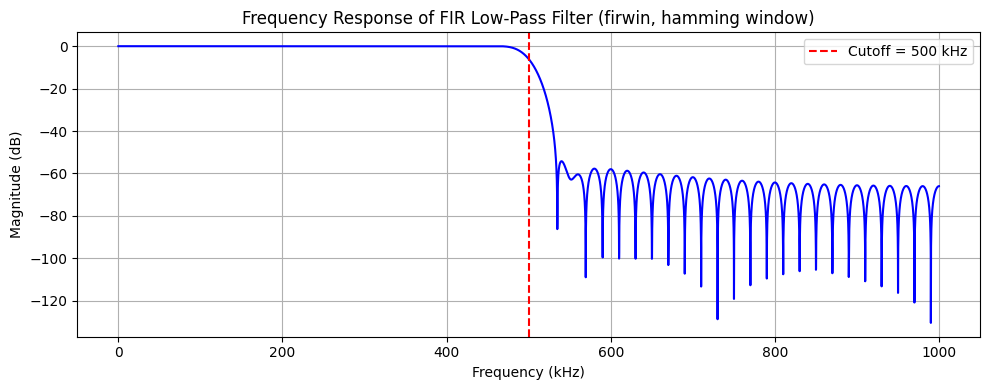

In [10]:
# Parameters
fs = 2e6       # Sampling frequency (Hz)
cutoff = 0.5e6 # Low-pass cutoff frequency (Hz)
numtaps = 101  # Length of the FIR filter
window = 'hamming'

# Design FIR filter using firwin
fir_coeffs = firwin(numtaps, cutoff=cutoff, fs=fs, window=window)

# Compute frequency response
w, h = freqz(fir_coeffs, worN=8000, fs=fs)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(w / 1e3, 20 * np.log10(np.abs(h)), color='blue')
plt.axvline(cutoff / 1e3, color='red', linestyle='--', label=f'Cutoff = {cutoff/1e3:.0f} kHz')
plt.title(f'Frequency Response of FIR Low-Pass Filter (firwin, {window} window)')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The frequency response shows that:
- Frequencies **below the cutoff** pass through _(passband)_
- Frequencies **above the cutoff** are attenuated _(stopband)_
- The transition band defines how quickly the filter rolls off

Now we shall apply this FIR Low-Pass Filter to our received signal.

In [11]:
def simulate_two_targets_with_IQ_demodulation_and_filter(
    target1=50.0, target2=100.0,
    fc=50e3, gamma=1e6, Tp=1e-3, fs=2e6
):
    t = np.linspace(0, Tp, int(fs * Tp))
    tx_signal = np.sin(2 * np.pi * fc * t + np.pi * gamma * (t - Tp / 2)**2)
    rx_signal = compute_received_signal(tx_signal, fs, t, target1, target2)

    # Plot Transmitted and Received
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=t * 1e3, y=tx_signal, mode='lines', name='Transmitted'))
    fig1.add_trace(go.Scatter(x=t * 1e3, y=rx_signal, mode='lines', name='Received (2 Targets)'))
    fig1.update_layout(
        title=f'2-Target Simulation | Target1: {target1:.1f} m, Target2: {target2:.1f} m',
        xaxis_title='Time (ms)',
        yaxis_title='Amplitude',
        legend_title='Signal'
    )
    fig1.show()

    # IQ Demodulation
    iq_signal = IQ_Demodulation(rx_signal, t, fc)

    # FIR Filter
    B = gamma * Tp
    cutoff = B / 2
    numtaps = 101
    fir_coeffs = firwin(numtaps, cutoff=cutoff, fs=fs, window='hamming')
    iq_filtered = lfilter(fir_coeffs, 1.0, iq_signal)

    # Plot IQ Time-Domain
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=t * 1e3, y=np.real(iq_filtered), mode='lines', name='In-phase (I)'))
    fig2.add_trace(go.Scatter(x=t * 1e3, y=np.imag(iq_filtered), mode='lines', name='Quadrature (Q)', line=dict(dash='dash')))
    fig2.update_layout(
        title="IQ Demodulated & Low-Pass Filtered Signal (Time Domain)",
        xaxis_title="Time (ms)",
        yaxis_title="Amplitude",
        legend_title="Component"
    )
    fig2.show()

    # FFT Plot
    N = len(iq_filtered)
    fft_vals = np.fft.fftshift(np.fft.fft(iq_filtered))
    fft_freqs = np.fft.fftshift(np.fft.fftfreq(N, d=1 / fs))
    fft_mag = np.abs(fft_vals)

    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=fft_freqs / 1e3, y=fft_mag, mode='lines', name='FFT Magnitude'))
    fig3.add_trace(go.Scatter(x=[0, 0], y=[0, max(fft_mag)], mode='lines', line=dict(color='red', dash='dot'), name='Baseband Centre (0 Hz)'))
    fig3.update_layout(
        title='FFT of Filtered IQ Signal (Baseband)',
        xaxis_title='Frequency (kHz)',
        yaxis_title='Magnitude',
        legend_title='Spectrum'
    )
    fig3.show()


In [12]:
interact(simulate_two_targets_with_IQ_demodulation_and_filter,
         target1=FloatSlider(min=0, max=50000, step=1, value=50, description='Target 1 (m)'),
         target2=FloatSlider(min=0, max=50000, step=1, value=100, description='Target 2 (m)'),
         fc=FloatSlider(min=10e3, max=200e3, step=10e3, value=50e3, description='f_c (Hz)'),
         gamma=FloatSlider(min=1e5, max=1e7, step=1e5, value=1e6, description='γ (Hz/s)'),
         Tp=FloatSlider(min=0.2e-3, max=5e-3, step=0.1e-3, value=1e-3, description='T_p (s)'),
         fs=FloatSlider(min=1e5, max=10e6, step=1e5, value=2e6, description='fs (Hz)')
        )

interactive(children=(FloatSlider(value=50.0, description='Target 1 (m)', max=50000.0, step=1.0), FloatSlider(…

<function __main__.simulate_two_targets_with_IQ_demodulation_and_filter(target1=50.0, target2=100.0, fc=50000.0, gamma=1000000.0, Tp=0.001, fs=2000000.0)>

## A Quick Note about Modulation and Demodulation
Above, we talked about baseband signals, but to fully understand their role in radar and communications, it’s important to understand modulation and demodulation.

### Baseband Signals
A **baseband signal** is the original, low-frequency signal that carries information — such as your voice, sensor data, or in our case, a chirp waveform. This signal typically ranges from 0 $Hz$ up to some bandwidth $B$ e.g., 500 $kHz$.

### Modulation: Lifting Signal to Carrier Frequency (Passband)
To transmit the baseband signal efficiently, we use modulation. This involves shifting the signal from baseband up to a higher frequency, called the carrier frequency $f_c$. This is done by multiplying the signal with a sinusoid:
$$
x_{mod}(t) = x(t) \cdot cos(2\pi f_c t)
$$
or using complex modulatin
$$
x_{mod}(t) = x(t) \cdot e^{j2\pi f_c t}
$$
In radar systems, this allows the signal to be transmitted at a high frequency (e.g. tens or hundreds of MHz), which supports higher resolution, longer range, and better antenna performance. This is required in radar so that our chirp signals are centred at a high frequency so they can bounce off distant targets and still be detectable.

### Demodulation: Bringing Signal Back to Baseband
When the reflected signal returns from a target, it is still centred around the carrier frequency $f_c$. To analyse it effectively (e.g., via FFT or matched filtering), we shift it back to baseband. This is done via IQ demodulation:
$$
x_{IQ}(t) = x_{rx}(t) \cdot e^{-2j\pi f_c t}
$$
This process shifts the spectrum down, centring it around 0 Hz, and produces a complex-valued signal with two parts:
- The in-phase (I) component
- The quadrature (Q) component

This complex representation retains both amplitude and phase information — crucial for radar processing.

## Matched Filtering (Pulse Compression)
Now that we have IQ-demodulated and low-pass filtered our received signal, we are ready to apply **matched filtering**.

Matched filtering is a technique used to **maximise** the **signal-to-noise ratio (SNR)** at the receiver by correlating the received signal with a reference (or template) signal that matches the expected shape of the transmitted pulse.

This is especially powerful in radar systems using chirp signals, because even though the chirp is long in time (wide pulse), matched filtering compresses it into a short, sharp peak, allowing for precise detection of echo time — hence the term pulse compression.

The following is the reference signal based on the chirp signal sent out we can ignore the $2\pi f_c t$ term as it just centres the sigmoid signal:

$$
s_{ref}(t) = e^{j\pi \gamma (t - \frac{T_p}{2})^2}
$$

In matched filtering, we want to find the correlation of the transmitted chirp signal to the received signal. This is done by sliding the transmitted chirp signal across the received signal in the time domain and finding the dot product to obtain the resulting amplitude. 

Recall, that to perform a correlation matching in the time domain it is the same as a convolution of the reversed signal. Additionally, based on the time-frequency duality, we have that a convolution in the time domain is a multiplication in the frequency domain. Below is a summary of the time-frequency duality for convolution/correlation:

| **Operation in Time Domain**                     | **Equivalent in Frequency Domain**         |
| ------------------------------------------------ | ------------------------------------------ |
| $x(t) * h(t)$ (Convolution)                      | $X(f) \cdot H(f)$ (Multiplication)         |
| $x(t) \cdot h(t)$ (Multiplication)               | $X(f) * H(f)$ (Convolution)                |
| $x(t) \star h(t) = x(t) * h^*(-t)$ (Correlation) | $X(f) \cdot H^*(f)$ (Mult. with conjugate) |

where $h^*$ is the conjugate term for $h$, it is needed to remove the complex term during correlation matching. 

To understand the Correlation row equations, we need to recall two properties of Fourier Transform:

---
## Time Reversal and Fourier Transforms

Let’s recall two properties of the Fourier Transform:

### 1. **Time reversal**:
If:

$$
h(t) \xrightarrow{\mathcal{F}} H(f)
$$

then:

$$
h(-t) \xrightarrow{\mathcal{F}} H(-f)
$$

### 2. **Complex conjugation**:

If:

$$
h(t) \xrightarrow{\mathcal{F}} H(f)
$$

then:

$$
h^*(t) \xrightarrow{\mathcal{F}} H^*(-f)
$$

Now apply **both** time reversal and conjugation:

$$
h^*(-t) \xrightarrow{\mathcal{F}} H^*(f)
$$

---

Now we are ready to perform matched filtering in the time domain for our chirp signal. That is, we will do a correlation matching in the time domain, which translates to multiplication of the reference signal with its conjugate in the frequency domain.

In [13]:
from scipy.signal import find_peaks

def simulate_two_targets_with_matched_filtering(
    target1=50.0, target2=100.0,
    fc=50e3, gamma=1e6, Tp=1e-3, fs=2e6
):
    c = 3e8  # speed of light (m/s)
    duration = 4 * Tp  # extend total observation time
    t = np.linspace(0, duration, int(fs * duration))

    # Zero-padded chirp signal
    tx_signal = np.zeros_like(t)
    t_chirp = t[:int(fs * Tp)]
    chirp = np.sin(2 * np.pi * fc * t_chirp + np.pi * gamma * (t_chirp - Tp / 2) ** 2)
    tx_signal[:len(chirp)] = chirp

    # Received signal with echoes
    rx_signal = compute_received_signal(tx_signal, fs, t, target1, target2)

    # Plot transmitted and received
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=t * 1e3, y=tx_signal, mode='lines', name='Transmitted'))
    fig1.add_trace(go.Scatter(x=t * 1e3, y=rx_signal, mode='lines', name='Received (2 Targets)'))
    fig1.update_layout(
        title=f'2-Target Simulation | Target1: {target1:.1f} m, Target2: {target2:.1f} m',
        xaxis_title='Time (ms)', yaxis_title='Amplitude', legend_title='Signal')
    fig1.show()

    # IQ Demodulation
    iq_signal = IQ_Demodulation(rx_signal, t, fc)

    # Low-pass FIR filter
    B = gamma * Tp  # Chirp bandwidth
    cutoff = B / 2
    numtaps = 101
    fir_coeffs = firwin(numtaps, cutoff=cutoff, fs=fs, window='hamming')
    iq_filtered = lfilter(fir_coeffs, 1.0, iq_signal)

    # Plot FFT of filtered IQ signal
    N = len(iq_filtered)
    fft_vals = np.fft.fftshift(np.fft.fft(iq_filtered))
    fft_freqs = np.fft.fftshift(np.fft.fftfreq(N, d=1 / fs))
    fft_mag = np.abs(fft_vals)

    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=fft_freqs / 1e3, y=fft_mag, mode='lines', name='FFT Magnitude'))
    fig3.add_trace(go.Scatter(x=[0, 0], y=[0, max(fft_mag)], mode='lines', line=dict(color='red', dash='dot'),
                              name='Baseband Centre (0 Hz)'))
    fig3.update_layout(
        title='FFT of Filtered IQ Signal (Baseband)',
        xaxis_title='Frequency (kHz)', yaxis_title='Magnitude', legend_title='Spectrum')
    fig3.show()

    # Matched Filtering
    ref_chirp = np.exp(1j * np.pi * gamma * (t[:len(chirp)] - Tp / 2) ** 2)
    ref_chirp_full = np.zeros_like(t, dtype=complex)
    ref_chirp_full[:len(ref_chirp)] = ref_chirp

    RX = np.fft.fft(iq_filtered)
    REF = np.fft.fft(ref_chirp_full)
    matched_filter_output = np.fft.ifft(RX * np.conj(REF))
    matched_mag = np.abs(matched_filter_output)

    # Find peaks in matched filter output
    peaks, _ = find_peaks(matched_mag, height=np.max(matched_mag)*0.2, distance=20)
    time_axis = np.linspace(0, duration, len(matched_mag))
    distances = (c * time_axis[peaks]) / 2

    # Plot matched filter output and annotate distances
    # We plot 20 * np.log10(matched_mag) because we want to take the power (decibels)
    fig4 = go.Figure()
    fig4.add_trace(go.Scatter(x=time_axis * 1e3, y=20 * np.log10(matched_mag), mode='lines', name='Matched Filter Output'))

    for i, peak in enumerate(peaks):
        fig4.add_trace(go.Scatter(
            x=[time_axis[peak] * 1e3],
            y=[20 * np.log10(matched_mag[peak])],
            mode='markers+text',
            text=[f"{distances[i]:.1f} m"],
            textposition="top center",
            marker=dict(color='red', size=8),
            name=f"Target {i+1}"
        ))

    fig4.update_layout(
        title='Matched Filtering Output with Estimated Distances',
        xaxis_title='Time (ms)', yaxis_title='Magnitude', legend_title='Detection Peaks')
    fig4.show()

In [14]:
interact(simulate_two_targets_with_matched_filtering,
         target1=FloatSlider(min=0, max=50000, step=1, value=100, description='Target 1 (m)'),
         target2=FloatSlider(min=0, max=50000, step=1, value=100, description='Target 2 (m)'),
         fc=FloatSlider(min=10e3, max=200e9, step=10e3, value=1e6, description='f_c (Hz)'),
         gamma=FloatSlider(min=1e5, max=1e14, step=1e5, value=(1e6*1e3), description='γ (Hz/s)'),
         Tp=FloatSlider(min=0.2e-3, max=5e-3, step=0.1e-9, value=1e-6, description='T_p (s)'),
         fs=FloatSlider(min=1e5, max=10e12, step=1e5, value=10e7, description='fs (Hz)')
        )

interactive(children=(FloatSlider(value=100.0, description='Target 1 (m)', max=50000.0, step=1.0), FloatSlider…

<function __main__.simulate_two_targets_with_matched_filtering(target1=50.0, target2=100.0, fc=50000.0, gamma=1000000.0, Tp=0.001, fs=2000000.0)>

We plot against power magnitude $20 log_{10}(y)$. This can be derived from $P = \frac{V^2}{R}$, ignoring $R$ we have $P = V^2$. Taking $10log_{10}$ on both sides, we have $10log_{10}(P) = 20log_{10}(V)$. This is also known as decibels $dB = 20log_{10}(V)$ 

In [15]:
10**(-0.3)

0.5011872336272722

In [16]:
def simulate_two_targets_with_matched_filtering_without_low_pass(
    target1=50.0, target2=100.0,
    fc=50e3, gamma=1e6, Tp=1e-3, fs=2e6
):
    c = 3e8  # speed of light (m/s)
    duration = 4 * Tp
    t = np.linspace(0, duration, int(fs * duration))

    # Zero-padded chirp signal
    tx_signal = np.zeros_like(t)
    t_chirp = t[:int(fs * Tp)]
    chirp = np.sin(2 * np.pi * fc * t_chirp + np.pi * gamma * (t_chirp - Tp / 2) ** 2)
    tx_signal[:len(chirp)] = chirp

    # Received signal with echoes
    rx_signal = compute_received_signal(tx_signal, fs, t, target1, target2)

    # Plot transmitted and received
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=t * 1e3, y=tx_signal, mode='lines', name='Transmitted'))
    fig1.add_trace(go.Scatter(x=t * 1e3, y=rx_signal, mode='lines', name='Received (2 Targets)'))
    fig1.update_layout(
        title=f'2-Target Simulation | Target1: {target1:.1f} m, Target2: {target2:.1f} m',
        xaxis_title='Time (ms)', yaxis_title='Amplitude', legend_title='Signal')
    fig1.show()

    # IQ Demodulation (no filtering)
    iq_signal = IQ_Demodulation(rx_signal, t, fc)

    # Plot FFT of IQ signal (not filtered)
    N = len(iq_signal)
    fft_vals = np.fft.fftshift(np.fft.fft(iq_signal))
    fft_freqs = np.fft.fftshift(np.fft.fftfreq(N, d=1 / fs))
    fft_mag = np.abs(fft_vals)

    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=fft_freqs / 1e3, y=fft_mag, mode='lines', name='FFT Magnitude'))
    fig3.add_trace(go.Scatter(x=[0, 0], y=[0, max(fft_mag)], mode='lines', line=dict(color='red', dash='dot'),
                              name='Baseband Centre (0 Hz)'))
    fig3.update_layout(
        title='FFT of IQ Signal (Baseband)',
        xaxis_title='Frequency (kHz)', yaxis_title='Magnitude', legend_title='Spectrum')
    fig3.show()

    # Matched Filtering
    ref_chirp = np.exp(1j * np.pi * gamma * (t[:len(chirp)] - Tp / 2) ** 2)
    ref_chirp_full = np.zeros_like(t, dtype=complex)
    ref_chirp_full[:len(ref_chirp)] = ref_chirp

    RX = np.fft.fft(iq_signal)
    REF = np.fft.fft(ref_chirp_full)
    matched_filter_output = np.fft.ifft(RX * np.conj(REF))
    matched_mag = np.abs(matched_filter_output)

    # Find peaks
    peaks, _ = find_peaks(matched_mag, height=np.max(matched_mag) * 0.2, distance=20)
    time_axis = np.linspace(0, duration, len(matched_mag))
    distances = (c * time_axis[peaks]) / 2

    # Plot matched filter output
    fig4 = go.Figure()
    fig4.add_trace(go.Scatter(x=time_axis * 1e3, y=20 * np.log10(matched_mag), mode='lines', name='Matched Filter Output'))

    for i, peak in enumerate(peaks):
        fig4.add_trace(go.Scatter(
            x=[time_axis[peak] * 1e3],
            y=[20 * np.log10(matched_mag[peak])],
            mode='markers+text',
            text=[f"{distances[i]:.1f} m"],
            textposition="top center",
            marker=dict(color='red', size=8),
            name=f"Target {i+1}"
        ))

    fig4.update_layout(
        title='Matched Filtering Output with Estimated Distances',
        xaxis_title='Time (ms)', yaxis_title='Magnitude (dB)', legend_title='Detection Peaks')
    fig4.show()


In [ ]:
interact(simulate_two_targets_with_matched_filtering_without_low_pass,
         target1=FloatSlider(min=0, max=50000, step=1, value=100, description='Target 1 (m)'),
         target2=FloatSlider(min=0, max=50000, step=1, value=100, description='Target 2 (m)'),
         fc=FloatSlider(min=10e3, max=200e9, step=10e3, value=1e6, description='f_c (Hz)'),
         gamma=FloatSlider(min=1e5, max=1e14, step=1e5, value=(1e6*1e3), description='γ (Hz/s)'),
         Tp=FloatSlider(min=0.2e-3, max=5e-3, step=0.1e-9, value=1e-6, description='T_p (s)'),
         fs=FloatSlider(min=1e5, max=10e12, step=1e5, value=50e7, description='fs (Hz)')
        )

interactive(children=(FloatSlider(value=100.0, description='Target 1 (m)', max=50000.0, step=1.0), FloatSlider…

<function __main__.simulate_two_targets_with_matched_filtering_without_low_pass(target1=50.0, target2=100.0, fc=50000.0, gamma=1000000.0, Tp=0.001, fs=2000000.0)>

In [24]:
# 3e8 * (1e-6 / 2) * 0.5
3e8 / 10e7


3.0

Low pass filter is actually not needed if we are doing matched filtering, because when doing the product in the frequency domain the portions whihc we do not care abpoit 

In [18]:
from scipy.signal.windows import taylor
from scipy.signal import find_peaks
import numpy as np
import plotly.graph_objects as go

def simulate_two_targets_with_matched_filtering_taylor(
    target1=50.0, target2=100.0,
    fc=50e3, gamma=1e6, Tp=1e-3, fs=2e6,
    nbar=4, sll=-40  # Taylor window parameters
):
    c = 3e8  # speed of light (m/s)
    duration = 4 * Tp
    N = int(fs * duration)
    t = np.linspace(0, duration, N)

    # Zero-padded chirp signal
    tx_signal = np.zeros_like(t)
    t_chirp = t[:int(fs * Tp)]
    chirp = np.sin(2 * np.pi * fc * t_chirp + np.pi * gamma * (t_chirp - Tp / 2) ** 2)
    tx_signal[:len(chirp)] = chirp

    # Received signal with echoes
    rx_signal = compute_received_signal(tx_signal, fs, t, target1, target2)

    # Plot transmitted and received
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=t * 1e3, y=tx_signal, mode='lines', name='Transmitted'))
    fig1.add_trace(go.Scatter(x=t * 1e3, y=rx_signal, mode='lines', name='Received (2 Targets)'))
    fig1.update_layout(
        title=f'2-Target Simulation | Target1: {target1:.1f} m, Target2: {target2:.1f} m',
        xaxis_title='Time (ms)', yaxis_title='Amplitude', legend_title='Signal')
    fig1.show()

    # IQ Demodulation (no filtering)
    iq_signal = IQ_Demodulation(rx_signal, t, fc)

    # --- Apply Taylor window to IQ signal safely ---
    try:
        if len(iq_signal) >= 2 * nbar:
            taylor_win_full = taylor(len(iq_signal), nbar=nbar, sll=sll, norm=False)
            iq_weighted = iq_signal * taylor_win_full
        else:
            print(f"Warning: IQ signal length ({len(iq_signal)}) too short for nbar={nbar}")
            iq_weighted = iq_signal
    except Exception as e:
        print(f"Taylor window application failed: {e}")
        iq_weighted = iq_signal

    # Plot Taylor-weighted IQ signal in dB
    iq_weighted_mag_dB = 20 * np.log10(np.abs(iq_weighted))
    iq_weighted_mag_dB = np.clip(iq_weighted_mag_dB, a_min=-80, a_max=None)

    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=t * 1e3, y=iq_weighted_mag_dB, mode='lines', name='Taylor-Weighted IQ'))
    fig2.update_layout(
        title=f'IQ Signal with Taylor Window Applied (nbar={nbar}, sll={sll} dB)',
        xaxis_title='Time (ms)', yaxis_title='Magnitude (dB)', legend_title='Windowed Signal')
    fig2.show()

    # Plot FFT of IQ signal (not filtered)
    fft_vals = np.fft.fftshift(np.fft.fft(iq_signal))
    fft_freqs = np.fft.fftshift(np.fft.fftfreq(N, d=1 / fs))
    fft_mag = np.abs(fft_vals)

    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=fft_freqs / 1e3, y=fft_mag, mode='lines', name='FFT Magnitude'))
    fig3.add_trace(go.Scatter(x=[0, 0], y=[0, max(fft_mag)], mode='lines', line=dict(color='red', dash='dot'),
                              name='Baseband Centre (0 Hz)'))
    fig3.update_layout(
        title='FFT of IQ Signal (Baseband)',
        xaxis_title='Frequency (kHz)', yaxis_title='Magnitude', legend_title='Spectrum')
    fig3.show()

    # Matched Filtering with Taylor window on reference chirp
    t_ref = t[:len(t_chirp)]
    ref_chirp = np.exp(1j * np.pi * gamma * (t_ref - Tp / 2) ** 2)

    try:
        if len(ref_chirp) >= 2 * nbar:
            taylor_win_ref = taylor(len(ref_chirp), nbar=nbar, sll=sll, norm=False)
            ref_chirp_weighted = ref_chirp * taylor_win_ref
        else:
            print(f"Warning: Ref chirp length too short for nbar={nbar}")
            ref_chirp_weighted = ref_chirp
    except Exception as e:
        print(f"Taylor window on ref chirp failed: {e}")
        ref_chirp_weighted = ref_chirp

    # Pad to full signal length
    ref_chirp_full = np.zeros_like(t, dtype=complex)
    ref_chirp_full[:len(ref_chirp_weighted)] = ref_chirp_weighted

    RX = np.fft.fft(iq_signal)
    REF = np.fft.fft(ref_chirp_full)
    matched_filter_output = np.fft.ifft(RX * np.conj(REF))
    matched_mag = np.abs(matched_filter_output)

    # Find peaks
    peaks, _ = find_peaks(matched_mag, height=np.max(matched_mag) * 0.2, distance=20)
    time_axis = np.linspace(0, duration, len(matched_mag))
    distances = (c * time_axis[peaks]) / 2

    # Plot matched filter output
    fig4 = go.Figure()
    fig4.add_trace(go.Scatter(x=time_axis * 1e3, y=20 * np.log10(matched_mag), mode='lines', name='Matched Filter Output'))

    for i, peak in enumerate(peaks):
        fig4.add_trace(go.Scatter(
            x=[time_axis[peak] * 1e3],
            y=[20 * np.log10(matched_mag[peak])],
            mode='markers+text',
            text=[f"{distances[i]:.1f} m"],
            textposition="top center",
            marker=dict(color='red', size=8),
            name=f"Target {i+1}"
        ))

    fig4.update_layout(
        title=f'Matched Filtering Output with Taylor Window (nbar={nbar}, sll={sll} dB)',
        xaxis_title='Time (ms)', yaxis_title='Magnitude (dB)', legend_title='Detection Peaks')
    fig4.show()


In [19]:
interact(simulate_two_targets_with_matched_filtering_taylor,
         target1=FloatSlider(min=0, max=50000, step=1, value=100, description='Target 1 (m)'),
         target2=FloatSlider(min=0, max=50000, step=1, value=100, description='Target 2 (m)'),
         fc=FloatSlider(min=10e3, max=200e9, step=10e3, value=1e6, description='f_c (Hz)'),
         gamma=FloatSlider(min=1e5, max=1e14, step=1e5, value=(1e6*1e3), description='γ (Hz/s)'),
         Tp=FloatSlider(min=0.2e-3, max=5e-3, step=0.1e-9, value=1e-6, description='T_p (s)'),
         fs=FloatSlider(min=1e5, max=10e12, step=1e5, value=10e7, description='fs (Hz)')
        )

interactive(children=(FloatSlider(value=100.0, description='Target 1 (m)', max=50000.0, step=1.0), FloatSlider…

<function __main__.simulate_two_targets_with_matched_filtering_taylor(target1=50.0, target2=100.0, fc=50000.0, gamma=1000000.0, Tp=0.001, fs=2000000.0, nbar=4, sll=-40)>

Above, the Taylor weighting is used to increase the chance of resolving two distinct targets that are close to each other. Taylor weighting trades off the width of the main lobe with a suppressed side lobe. This reduces the effect of a side lobe covering a main lobe of another weaker target. However, when increasing the main lobe's width, we will inherently increase the resolution which will usually be compensated by increasing the transmitted bandwidth by a coefficient of $0.2$.